In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import keras as K
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Input,Activation, concatenate, Embedding, Reshape
from keras.layers import Merge, Flatten, merge, Lambda, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.models import model_from_json
from keras.models import load_model
from keras.regularizers import l1,l2
import tensorflow as tf
import gc

/Users/BharathiSrinivasan/anaconda2/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
df = pd.read_csv('/Users/BharathiSrinivasan/Documents/GitHub/Thesis/data_final.csv', index_col=[0])

/Users/BharathiSrinivasan/anaconda2/envs/python36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [20]:
df.shape

(1251273, 18)

In [21]:
df.drop(['index'],inplace=True,axis=1)

In [22]:
#Investigating NAs
print(df.isnull().sum().sum())

344407


In [23]:
df.dropna(axis=0, inplace=True, how = 'all')

In [48]:
df.drop(['prd_reorder_freq'], axis=1,inplace = True)

In [49]:
df.dtypes

product_id                  int64
add_to_cart_order           int64
reordered                   int64
user_id                     int64
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
product_name               object
aisle_id                    int64
department_id               int64
department                 object
user_period               float64
user_distinct_products      int64
user_average_basket       float64
product_id_orders           int64
dtype: object

In [50]:
df.isnull().values.sum(axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

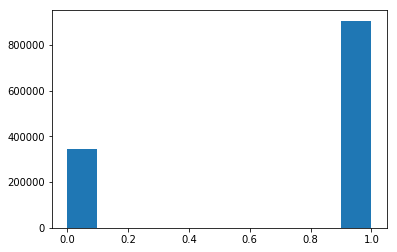

In [51]:
plt.figure()
plt.hist(df.reordered)
plt.show()

In [77]:
df_small = df.sample(frac = 0.8)

In [78]:
CATEGORICAL_COLUMNS = ["order_dow", "order_hour_of_day","aisle_id","department_id"]
CONTINUOUS_COLUMNS = ["days_since_prior_order","order_number","add_to_cart_order", \
                     "user_period","user_distinct_products", \
                     "user_average_basket","product_id_orders"]

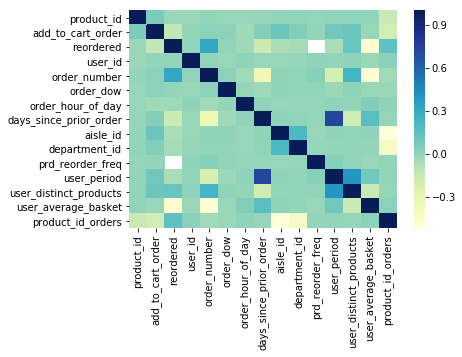

In [28]:
import seaborn as sns
sns.heatmap(df_small.corr(),cmap="YlGnBu")

In [79]:
#One-hot encoding categorical columns
df_small = pd.get_dummies(df_small, columns=[x for x in CATEGORICAL_COLUMNS])

In [80]:
#Normalising the feature columns
df_small[CONTINUOUS_COLUMNS] = MinMaxScaler().fit_transform(df_small[CONTINUOUS_COLUMNS].values)

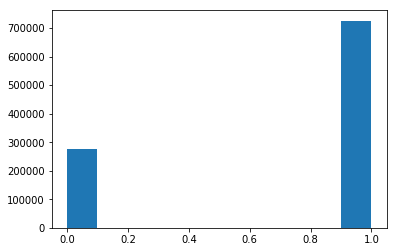

In [81]:
plt.figure()
plt.hist(df_small.reordered)
plt.show()

In [16]:
#Prepare embedding layer as separate input to Keras
#embed_vectors = df_small['prod_embedding']
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((df_small.shape[0],EMBEDDING_DIM ))
embedding_matrix = df_small.set_index('product_id').prod_embedding
embedding_matrix = embedding_matrix.drop_duplicates()

embedding_train = X_train.set_index(X_train.index).product_id
X_train.drop(['product_id'], inplace=True, axis = 1)

from keras.preprocessing.sequence import pad_sequences
embed_raw_input = pad_sequences(embedding_train, maxlen=10)

import gensim
word2vec_model = gensim.models.Word2Vec.load('/Users/BharathiSrinivasan/Documents/GitHub/Thesis/BNN_Rec_Sys/word2vec.model')

source_word_indices = []
for i in range(len(array_of_word_lists)):
    source_word_indices.append([])
    for j in range(len(array_of_word_lists[i])):
        word = array_of_word_lists[i][j]
        if word in word2vec_model.wv.vocab:
            word_index = word2vec_model.wv.vocab[word].index
            source_word_indices[i].append(word_index)
        else:
            # Do something. For example, leave it blank or replace with padding character's index.
            source_word_indices[i].append(padding_index)
source = numpy.array(source_word_indices)

In [82]:
df_small.drop(['product_name','department'], axis=1, inplace=True)

In [83]:
df_small.drop(['product_id'], axis = 1, inplace=True)

In [84]:
df_small.drop(['user_id'], axis=1, inplace= True)

In [88]:
y = df_small.reordered.values

In [89]:
df_small.drop(['reordered'], axis=1, inplace = True)

In [90]:
X_train, X_remain, y_train, y_remain = train_test_split(df_small, y, test_size=0.20, random_state=42, stratify=y)

In [20]:
#X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=0.20, random_state=42, stratify=y_remain)

In [91]:
reg= 0.4

#embedding_input = Input(shape = (embedding_train.shape[0],))
#embedding_layer = Embedding(input_dim = len(embedding_matrix), output_dim = len(embedding_matrix.columns),\
                            #input_length=data.shape[1:]
                            #weights=[embedding_matrix],
                            #trainable=False)(embedding_input)

#embedding_layer = word2vec_model.wv.get_keras_embedding(train_embeddings=False)
input_tensor = Input(shape=X_train.shape[1:])
#combined_input = merge([input_tensor, embedding_layer], mode='concat')
#combined_input = Flatten(combined_input)

#x = BatchNormalization()(input_tensor)
x = Dropout(0.3)(input_tensor)
x = Dense(200, activation='tanh',kernel_regularizer=l2(0.01),activity_regularizer=l1(0.01))(x)
x = BatchNormalization()(x)

x = Dropout(0.3)(x)
x = Dense(100, activation='tanh',W_regularizer=l2(reg))(x)
x = BatchNormalization()(x)

logits = Dense(1,activation='tanh',kernel_regularizer=l2(0.01),activity_regularizer=l1(0.01))(x)
#variance_pre = Dense(1)(x)
#variance = Activation('softplus', name='variance')(variance_pre)
#logits_variance = concatenate([logits, variance], name='logits_variance')
softmax_output = Activation('softmax', name='softmax_output')(logits)

model = Model(inputs=input_tensor, outputs=softmax_output)

/Users/BharathiSrinivasan/anaconda2/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="tanh", kernel_regularizer=<keras.reg...)`


In [92]:
model.compile(optimizer='adam', \
              loss='binary_crossentropy',\
              metrics=['binary_accuracy'] )

In [93]:
model.fit(X_train,y_train, batch_size = 100, epochs = 2)

Epoch 1/2
800814/800814 [==============================] - 51s 64us/step - loss: 5.0444 - binary_accuracy: 0.7249
Epoch 2/2
800814/800814 [==============================] - 50s 62us/step - loss: 4.5270 - binary_accuracy: 0.7249


In [94]:
score = model.evaluate(X_remain, y_remain, verbose=1)
print('Test accuracy:', score[1])

200204/200204 [==============================] - 8s 38us/step
Test accuracy: 0.7249205810061816


In [45]:
T=100
Yt_hat = []
for _ in range(T):
    Yt_hat += [model.predict(X_remain,verbose=0)]

In [62]:
# 100 arrays with one output of each observation for X_test
probs = np.array(Yt_hat)

In [64]:
np.shape(probs[:,1].reshape(-1))

(100,)

In [47]:
predictive_mean = np.mean(Yt_hat, axis=0)

In [48]:
predictive_variance = np.var(Yt_hat, axis = 0)

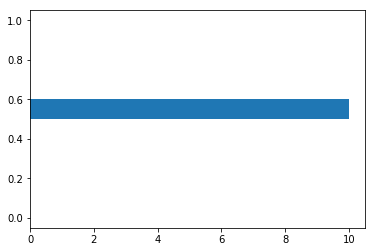

In [74]:
#Stacked bar histogram of output probabilities
plt.figure()
x1=probs[:,1].reshape(-1)
x2 = probs[:,20].reshape(-1)
x3 = probs[:,10].reshape(-1)
plt.hist(x1,normed=True)
plt.show()

In [55]:
Yt_hat[1].reshape(-1)

array([0.50011355, 0.50011355, 0.5001136 , ..., 0.50011355, 0.50011355,
       0.50011355], dtype=float32)